In [15]:
import pandas as pd
import json
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# df.to_json('../data/cleaned/manifold_samples_cleaned.json', orient='records')

In [16]:
with open('../../data/raw/manifold_samples_5k.json', 'r') as file:
    data_manifold = json.load(file)

df_unflatted_manifold = pd.DataFrame(data_manifold)
def text_join(text_list):
    return " ".join(text_list)

df_unflatted_manifold['joined_texts'] = df_unflatted_manifold['texts'].apply(text_join)
df_manifold = df_unflatted_manifold[['id', 'joined_texts']].copy()
df_manifold.rename(columns={'joined_texts': 'text'}, inplace=True)

In [17]:
df_manifold

,id,text
0,bvcuvqhsvg5,Quantum Entanglement babyyy
1,fqjavdtue4j,Good catch. Updated the description: Yes for ...
2,aig292awtb6,All of our ingredients are ethically sourced.
3,567lbqb2dyp,seems right:
4,t04x2msdwls,to the moon
...,...,...
4995,gbh6pmqXj2S8iT2LHpmd,"Who is the Best Talk Show host? , 8k, beautifu..."
4996,4b5j4711zbu,"Hindus, on the other hand … never had any beef."
4997,3t3f2capyd6,Deleted.
4998,V5HM37f8PKLber60LkDB,"By browsing all market topics, filtering to re..."


In [18]:
with open('../../data/raw/reddit_samples_5k.json', 'r') as file:
    data_reddit = json.load(file)

df_reddit = pd.DataFrame(data_reddit)

In [19]:
df_reddit

,id,text
0,e6pqrs5,Lol
1,e651y5k,You're just privileged
2,e59xkgh,"I wasn't saying that it was weird, I was just ..."
3,e6v3h7b,The 30 shekels Judas received would have been ...
4,e6ob8z7,Literally nothing is taken away from Solaires ...
...,...,...
4995,e6a5apg,[removed]
4996,e64ftgm,"Okay, I may be wrong, but there is a differenc..."
4997,e6a8e1w,&gt; If she was just some random imposter girl...
4998,e6g3len,Hm the HoT HPs are so overrated. \n\n\nNo joke...


In [20]:
def text_processing(text):
    url_pattern = r'https?://\S+|www\.\S+'  # URL pattern
    clean_text = re.sub(url_pattern, '[URL]', text)  # replace URLs with '[URL]'
    clean_text = clean_text.encode('ascii', 'ignore').decode('ascii')  # remove non-ascii characters
    clean_text = clean_text.strip()  # remove trailing spaces
    # only check if entire entry is one word
    if len(clean_text.split()) == 1:
        return None  # if only one word is present, return None to indicate filtering out this row
    return clean_text  # otherwise, return the cleaned text
df_manifold['text'] = df_manifold['text'].apply(text_processing)
df_reddit['text'] = df_reddit['text'].apply(text_processing)


In [21]:
empty_rows_manifold = df_manifold[df_manifold['text'].isnull() | (df_manifold['text'] == '')].count()
empty_rows_reddit = df_reddit[df_reddit['text'].isnull() | (df_reddit['text'] == '')].count()

def drop_null(df):
    return df[df['text'].notnull() & (df['text'] != '')]

df_manifold = drop_null(df_manifold)
df_reddit = drop_null(df_reddit)

In [22]:
empty_rows_manifold, empty_rows_reddit

(id      529
 text    229
 dtype: int64,
 id      634
 text     69
 dtype: int64)

In [23]:
model_id="/users/p/s/psuchdev/LLM/models/huggingface/13Bf"
tokenizer = LlamaTokenizer.from_pretrained(model_id)

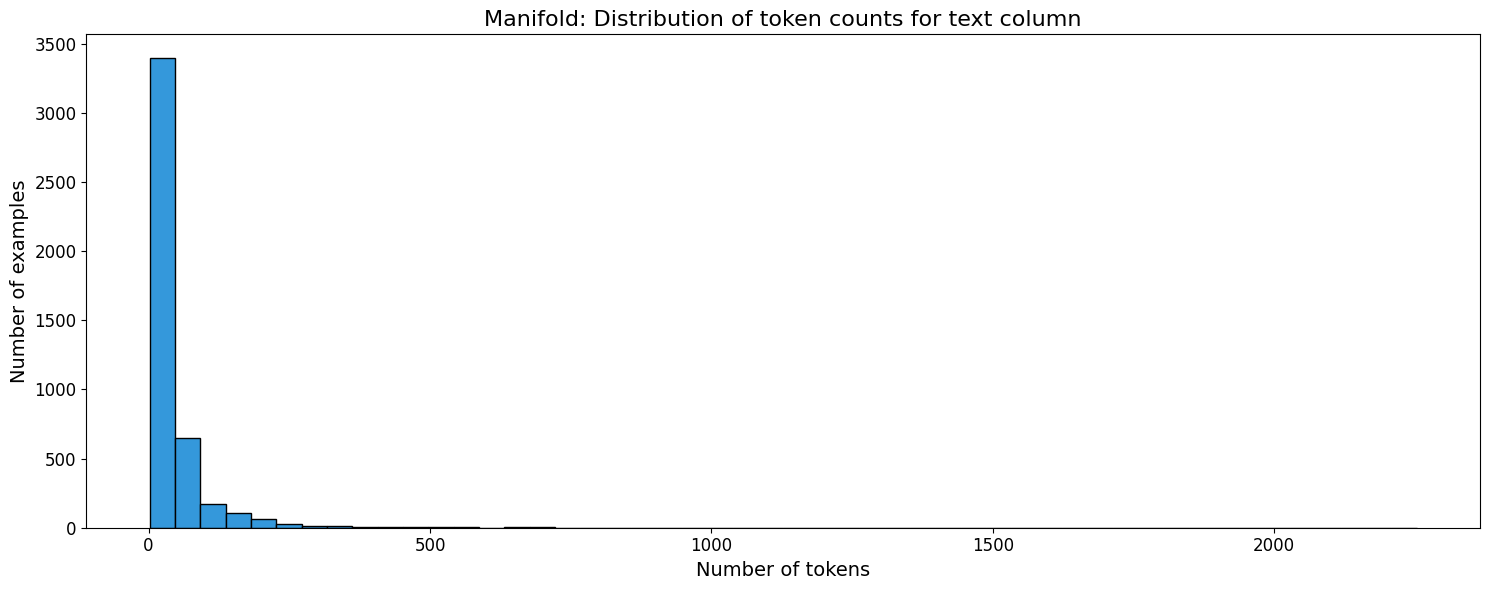

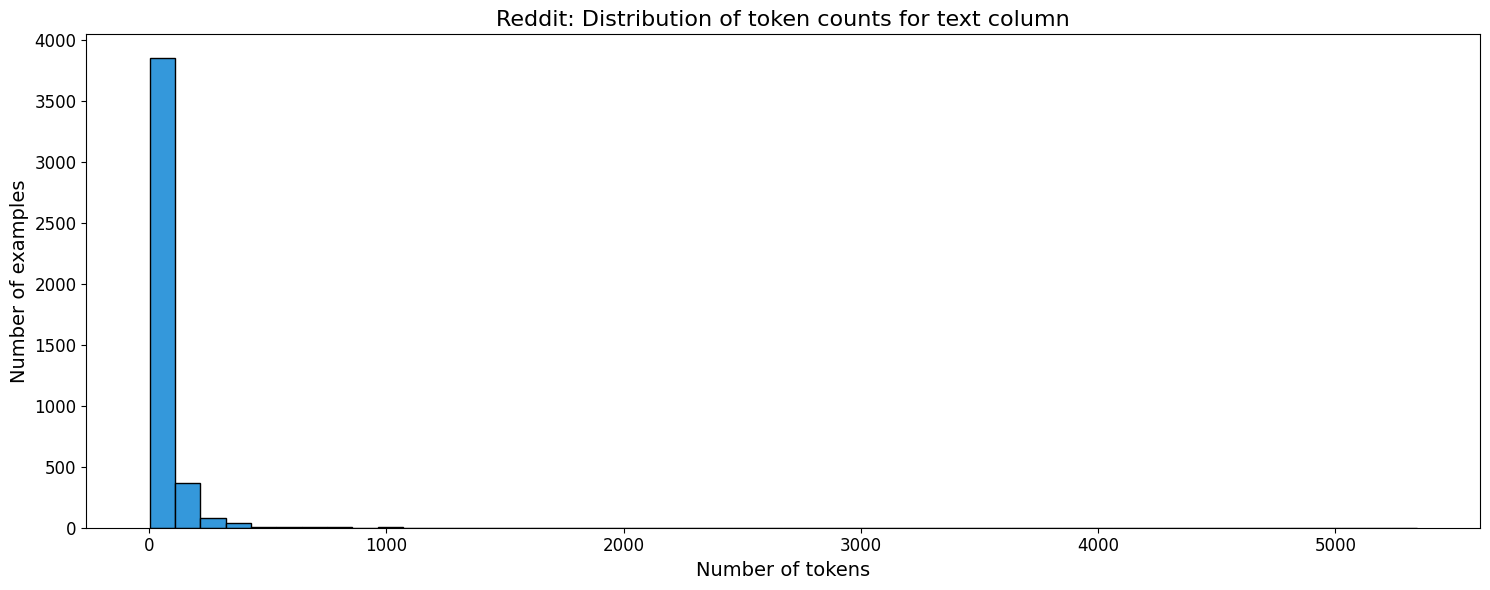

In [24]:
def init_tokenizer(df):
    return [len(tokenizer.tokenize(text)) for text in df["text"]]

def plot_distribution(token_counts, title, save_path):
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path)  # Save the figure
    plt.show()

token_count_manifold = init_tokenizer(df_manifold)
token_count_reddit = init_tokenizer(df_reddit)

plot_distribution(token_count_manifold, "Manifold: Distribution of token counts for text column", '../figures/preprocessing/token_plt_m.png')
plot_distribution(token_count_reddit, "Reddit: Distribution of token counts for text column", '../figures/preprocessing/token_plt_r.png')

Number of valid rows: 4467
Removing 4 rows...
Number of valid rows: 4362
Removing 4 rows...


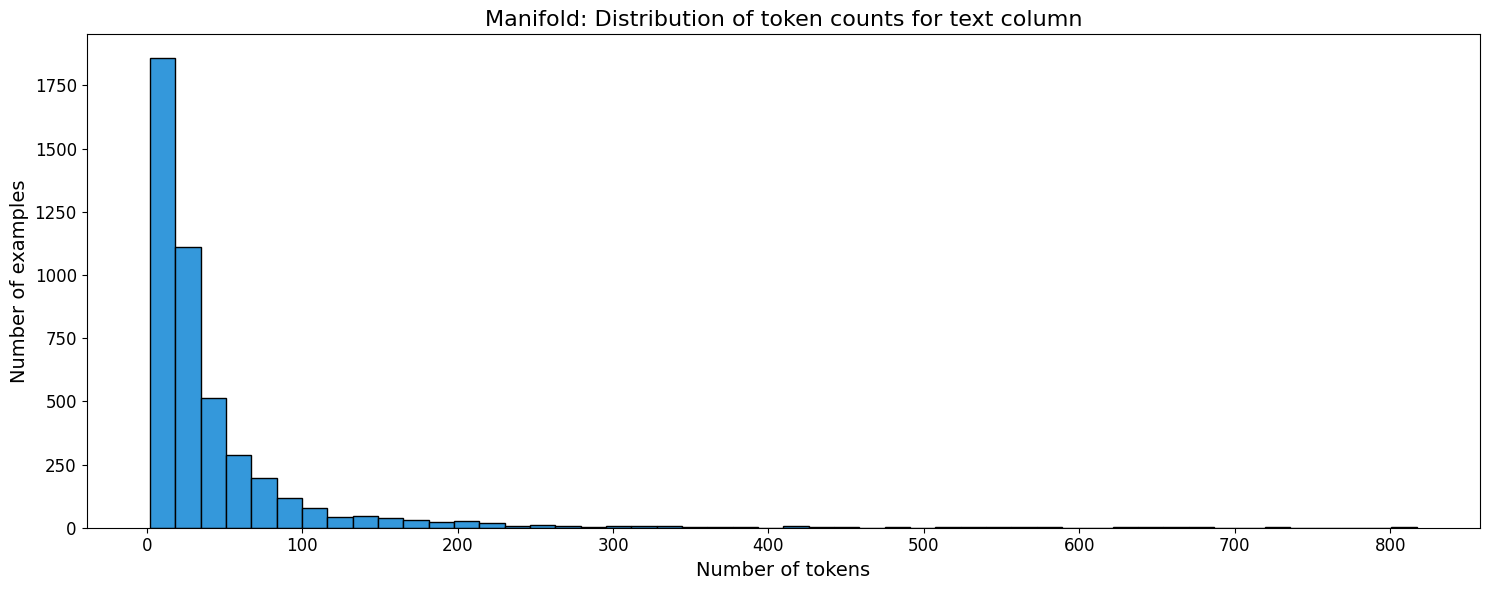

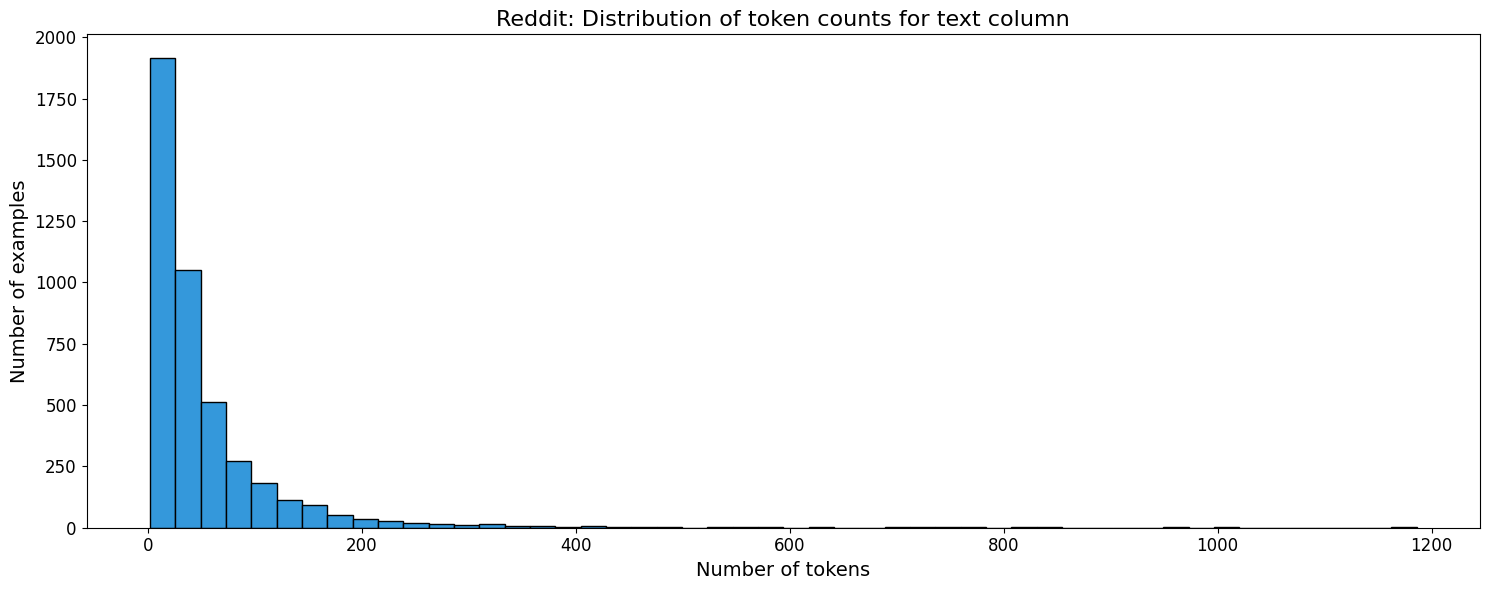

In [25]:
def filter_rows_by_token_count(df, token_count, max_tokens=1000):
    # filter out rows with more than max_tokens tokens
    valid_indices = [i for i, count in enumerate(token_count) if count <= max_tokens]
    print(f"Number of valid rows: {len(valid_indices)}")
    print(f"Removing {len(df['text']) - len(valid_indices)} rows...")

    # extract valid rows based on indices
    df = df.iloc[valid_indices]
    # get token counts for valid rows
    token_counts = [token_count[i] for i in valid_indices]
    return df, token_counts

filter_manifold, new_tokens_m= filter_rows_by_token_count(df_manifold, token_count_manifold, max_tokens=900)
filter_reddit, new_tokens_r= filter_rows_by_token_count(df_reddit, token_count_reddit, max_tokens=1200)

plot_distribution(new_tokens_m, "Manifold: Distribution of token counts for text column", '../figures/preprocessing/new_token_plt_m.png')
plot_distribution(new_tokens_r, "Reddit: Distribution of token counts for text column", '../figures/preprocessing/new_token_plt_r.png')

In [26]:
filter_manifold

,id,text
0,bvcuvqhsvg5,Quantum Entanglement babyyy
1,fqjavdtue4j,Good catch. Updated the description: Yes for V...
2,aig292awtb6,All of our ingredients are ethically sourced.
3,567lbqb2dyp,seems right:
4,t04x2msdwls,to the moon
...,...,...
4992,VZqfOVJ1utAApgyPGYt7,I think some large portion would even be okay ...
4994,1KyhyFz78cAVaTqgpdHF,"@ThatGuy Can you resolve, please?"
4995,gbh6pmqXj2S8iT2LHpmd,"Who is the Best Talk Show host? , 8k, beautifu..."
4996,4b5j4711zbu,"Hindus, on the other hand never had any beef."


In [27]:
filter_reddit

,id,text
1,e651y5k,You're just privileged
2,e59xkgh,"I wasn't saying that it was weird, I was just ..."
3,e6v3h7b,The 30 shekels Judas received would have been ...
4,e6ob8z7,Literally nothing is taken away from Solaires ...
5,e6i9vz5,Well I used to work as a store clerk so I gues...
...,...,...
4994,e66k3y0,Youre being literal. There is such a thing as ...
4996,e64ftgm,"Okay, I may be wrong, but there is a differenc..."
4997,e6a8e1w,&gt; If she was just some random imposter girl...
4998,e6g3len,Hm the HoT HPs are so overrated. \n\n\nNo joke...


In [28]:
filter_reddit.to_json('../../data/cleaned/reddit_samples_cleaned.json', orient='records')
filter_manifold.to_json('../../data/cleaned/manifold_samples_cleaned.json', orient='records')